Notebook to calculate and save place field correlation mean and hierarchically bootstrapped values

In [7]:
import scipy.stats as sstats
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror, fix_xlabels
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import cell_tracking as ct
import er_plot_functions as erp
from helpers import flatten
from stats_utils import resample, get_bootstrap_prob, get_bootstrap_prob_paired

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Definitions

In [3]:
day_dict = {"Before" : [-2, -1], "Before v After" : [-1, 1], "After" : [1, 2], "After2": [2, 7]}

In [5]:
gen_sesh_id = lambda row : f"{row['arena1']}{row['day1']}_{row['arena2']}{row['day2']}"

### Before (Day -2 to -1) correlations

In [116]:
df_bs, corr_df_all = [], []
epoch = 'Before'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_before")
save_df(df_bs, "group_pf_corrs_before_bootstrap")

Loading previous 2d placefield analysis for Marble07 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble12 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble24 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble27 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble06 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble11 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble29 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble17 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble18 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble19 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble20 Shock day -2 to Shock day -1
Loading previous 2d placefield analysis for Marble25 Shock day -2 to Shock day -1
Loading previous

### Calculate Before v After (Day -1 to Day 1) correlations

In [150]:
df_bs, corr_df_all = [], []
epoch = 'Before v After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_before_after")
save_df(df_bs, "group_pf_corrs_before_after_bootstrap")

Loading previous 2d placefield analysis for Marble07 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble12 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble24 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble27 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble06 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble11 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble29 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble17 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble18 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble19 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble20 Shock day -1 to Shock day 1
Loading previous 2d placefield analysis for Marble25 Shock day -1 to Shock day 1
Loading previous 2d placefie

### After correlations

In [117]:
df_bs, corr_df_all = [], []
epoch = 'After'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})
corr_df_all.loc[corr_df_all.Arena == "Open", "Arena"] = "Neutral"

save_df(corr_df_all, "group_pf_corrs_after")
save_df(df_bs, "group_pf_corrs_after_bootstrap")

Loading previous 2d placefield analysis for Marble07 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble12 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble24 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble27 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble06 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble11 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble29 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble17 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble18 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble19 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble20 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis for Marble25 Shock day 1 to Shock day 2
Loading previous 2d placefield analysis 

In [126]:
df_bs, corr_df_all = [], []
epoch = 'After2'
resample_levels = ["mouse", "session", "corrs_sm"]
for arena, arena_name in zip(['Shock', 'Open'], ['Shock', 'Neutral']):
    
    for group_name, mice in zip(["Learners", "Non-Learners", "ANI"], 
                                [err.learners, err.nonlearners, err.ani_mice_good]):
        df_list = []
        for mouse in mice:
            day1, day2 = day_dict[epoch]
            df_list.append(pfs.pf_corrs_to_df(mouse, arena, day1, arena, day2))
        
        corr_df = pd.concat(df_list)
        corr_df.insert(0, column='Group', value=group_name)
        corr_df.insert(1, column="session_pair", value=corr_df.apply(gen_sesh_id, axis=1))
        corr_df_all.append(corr_df)
        means = []
        for ii in range(10000):
            t = resample(corr_df, level=['mouse', 'session_pair', 'corrs_sm'])
            means.append(t.corrs_sm.mean())
        df_bs.append(pd.DataFrame({"Group": group_name, "Arena": arena_name, "Comparison": epoch, "Mean PF Corr": means}))
df_bs = pd.concat(df_bs)
corr_df_all = pd.concat(corr_df_all)
corr_df_all = corr_df_all.rename(columns={"arena1" : "Arena"})

save_df(corr_df_all, "group_pf_corrs_after2")
save_df(df_bs, "group_pf_corrs_after2_bootstrap")

Loading previous 2d placefield analysis for Marble07 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble12 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble24 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble27 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble06 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble11 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble29 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble17 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble18 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble19 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble20 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis for Marble25 Shock day 2 to Shock day 7
Loading previous 2d placefield analysis 

### Quick and dirty plots
real stuff in `Figure2_and_S4-5.ipynb`

In [153]:
corr_means.rename(

,Group,Arena,mouse,0
0,Learners,Neutral,Marble07,0.202544
1,Learners,Neutral,Marble12,0.442495
2,Learners,Neutral,Marble24,0.207987
3,Learners,Neutral,Marble27,0.111041
4,Learners,Shock,Marble07,0.236512
5,Learners,Shock,Marble12,0.559213
6,Learners,Shock,Marble24,0.202890
7,Learners,Shock,Marble27,0.130429
8,Non-Learners,Neutral,Marble06,0.227762
9,Non-Learners,Neutral,Marble11,0.238532


In [158]:
corr_means.rename(columns={0 : "corrs_sm"})

,Group,Arena,mouse,corrs_sm
0,Learners,Neutral,Marble07,0.202544
1,Learners,Neutral,Marble12,0.442495
2,Learners,Neutral,Marble24,0.207987
3,Learners,Neutral,Marble27,0.111041
4,Learners,Shock,Marble07,0.236512
5,Learners,Shock,Marble12,0.559213
6,Learners,Shock,Marble24,0.202890
7,Learners,Shock,Marble27,0.130429
8,Non-Learners,Neutral,Marble06,0.227762
9,Non-Learners,Neutral,Marble11,0.238532


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_58419/2404260363.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_means = corr_df.drop(columns=["session_pair", "arena1", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).reset_index()
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_58419/2404260363.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_means = corr_df.drop(columns=["session_pair", "arena1", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).reset_index()
/var/folders/7g/v7xwy2

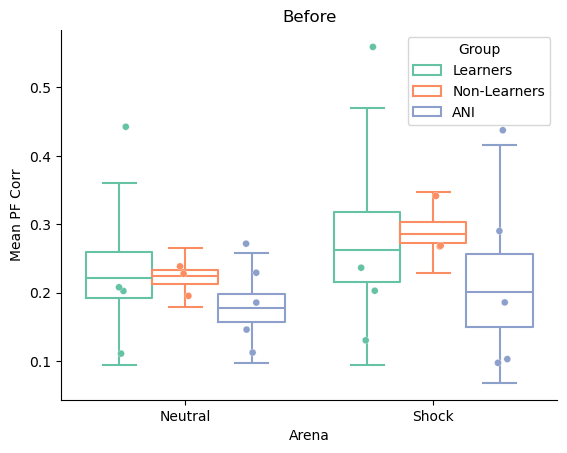

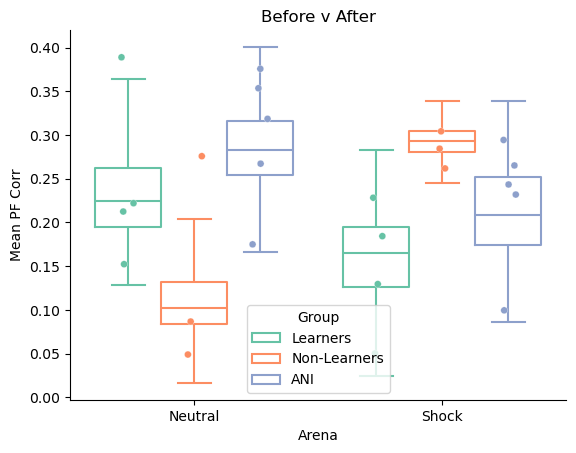

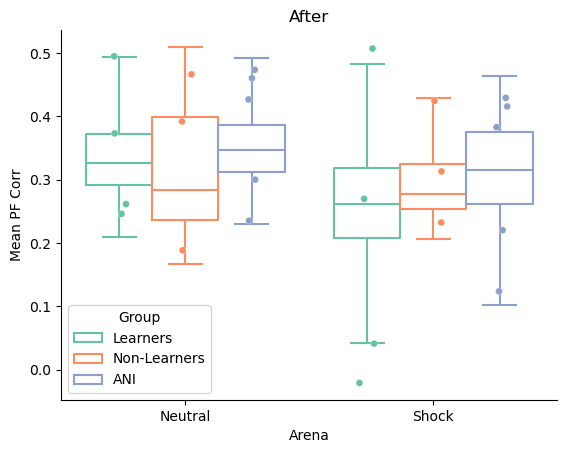

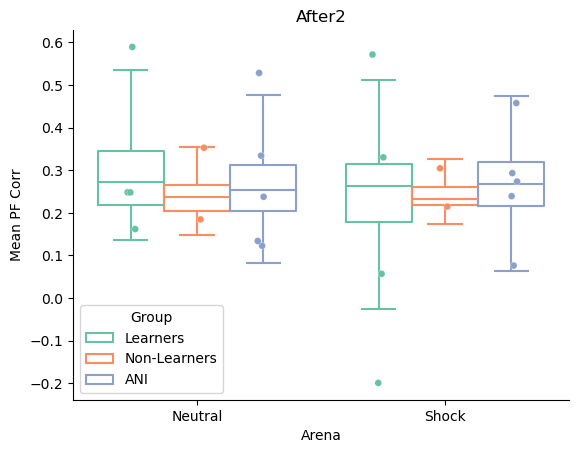

In [163]:
for varname, epoch_name in zip(["before", "before_after", "after", "after2"],
                               ["Before", "Before v After", "After", "After2"]):

    corr_df = load_df(f"group_pf_corrs_{varname}")
    boot_df = load_df(f"group_pf_corrs_{varname}_bootstrap")

    corr_df.loc[corr_df.Arena == "Open", "Arena"] = "Neutral" 
    corr_df["Group"] = pd.Categorical(corr_df["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_df["arena1"] = pd.Categorical(corr_df["Arena"], ["Neutral", "Shock"])
    
    boot_df["Group"] = pd.Categorical(boot_df["Group"], ["Learners", "Non-Learners", "ANI"])
    boot_df["Arena"] = pd.Categorical(boot_df["Arena"], ["Neutral", "Shock"])
    
    
    # corr_means = corr_df.groupby(["Group", "Arena", "mouse"]).mean(numeric_only=True).reset_index()
    # corr_means = corr_df.groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).
    corr_means = corr_df.drop(columns=["session_pair", "arena1", "day1", "arena2", "day2", "pair_no"]).groupby(["Group", "Arena", "mouse"]).apply(np.nanmean).reset_index()
    corr_means = corr_means.rename(columns={0: "corrs_sm"})
    corr_means["Group"] = pd.Categorical(corr_means["Group"], ["Learners", "Non-Learners", "ANI"])
    corr_means["arena1"] = pd.Categorical(corr_means["Arena"], ["Neutral", "Shock"])
    
    _, ax = plt.subplots()
    pal_use = sns.color_palette(palette='Set2', as_cmap=False)[0:3] 
    sns.boxplot(data=boot_df, x="Arena", y="Mean PF Corr", hue="Group", showfliers=False, fill=False, palette=pal_use, ax=ax)
    sns.stripplot(data=corr_means, x="Arena", y="corrs_sm", hue="Group", dodge=True, palette=pal_use, linewidth=0.2, edgecolor='w',
                  ax=ax, legend=False)
    sns.despine(ax=ax)
    ax.set_title(epoch_name)